In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('../data/day_ahead_energy_prices.csv', delimiter=",")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)

In [10]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = df.index[int(TEST_SIZE * len(df))]


train = df.loc[df.index < SPLIT_DATE_EVAL]
initial_test = df.loc[df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = df.index[int(TEST_SIZE * len(df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price
Datetime,
2023-12-20 09:00:00+00:00,67.93
2023-12-20 08:00:00+00:00,70.54
2023-12-20 07:00:00+00:00,72.93
2023-12-20 06:00:00+00:00,67.96
2023-12-20 05:00:00+00:00,46.72
...,...
2023-02-09 00:00:00+00:00,118.36
2023-02-08 23:00:00+00:00,109.56
2023-02-08 22:00:00+00:00,118.94


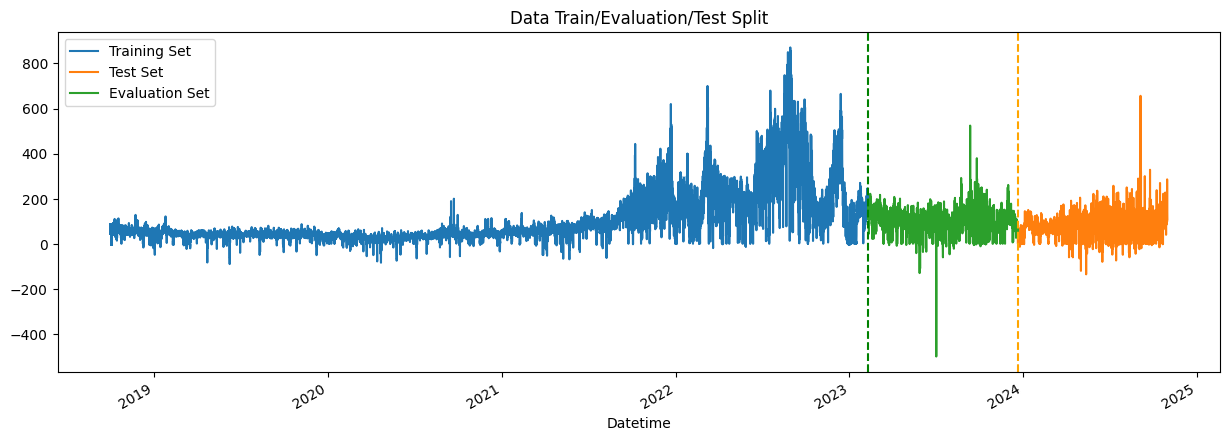

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test.plot(ax=ax, label='Test Set')
eval.plot(ax=ax, label='Evaluation Set')
ax.axvline(SPLIT_DATE_EVAL, color='green', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='orange', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [12]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()

    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days
Datetime,,,,,,,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-29 21:00:00+00:00,118.08,21,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-29 20:00:00+00:00,124.05,20,1,303,44,115.073333,NaN,NaN,NaN,NaN,NaN
2024-10-29 19:00:00+00:00,140.60,19,1,303,44,127.576667,NaN,NaN,NaN,NaN,NaN
2024-10-29 18:00:00+00:00,203.82,18,1,303,44,156.156667,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 02:00:00+00:00,47.59,2,0,274,40,56.110000,68.363333,65.673333,59.686667,40.311806,51.451071
2018-10-01 01:00:00+00:00,47.38,1,0,274,40,48.860000,63.000000,65.205000,59.837083,40.318750,51.451071
2018-10-01 00:00:00+00:00,51.41,0,0,274,40,48.793333,57.406667,64.807500,60.143333,40.399444,51.451071


In [ ]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

best_params = {
    "base_score": np.float64(0.5821530365189468),
    "colsample_bytree": np.float64(0.8946581179883414),
    "early_stopping_rounds": np.int64(5),
    "gamma": np.float64(0.4754258184197202),
    "learning_rate": np.float64(1.240350026692638),
    "max_depth": np.int64(5),
    "min_child_weight": np.int64(4),
    "n_estimators": np.int64(450),
    "subsample": np.float64(0.8711382010561193),
}

reg = xgb.XGBRegressor(
    base_score=best_params["base_score"],
    colsample_bytree=best_params["colsample_bytree"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    gamma=best_params["gamma"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    objective="reg:squarederror",
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=25)

KeyError: "None of [Index(['hour', 'dayofyear', 'dayofweek', 'ma_3_hours', 'ma_6_hours',\n       'ma_1_days', 'ma_3_days', 'ma_7_days'],\n      dtype='object')] are in the [columns]"

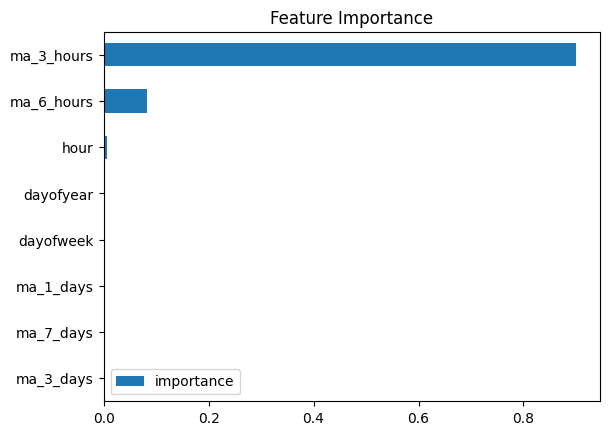

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
test['prediction'] = reg.predict(X_test)
test

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days,prediction
Datetime,,,,,,,,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN,102.871948
2024-10-29 21:00:00+00:00,118.08,21,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN,102.871948
2024-10-29 20:00:00+00:00,124.05,20,1,303,44,115.073333,NaN,NaN,NaN,NaN,NaN,98.723587
2024-10-29 19:00:00+00:00,140.60,19,1,303,44,127.576667,NaN,NaN,NaN,NaN,NaN,118.422562
2024-10-29 18:00:00+00:00,203.82,18,1,303,44,156.156667,NaN,NaN,NaN,NaN,NaN,160.957001
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20 14:00:00+00:00,69.98,14,2,354,51,74.570000,77.561667,59.882500,40.982500,29.160139,22.869107,58.676285
2023-12-20 13:00:00+00:00,66.80,13,2,354,51,70.090000,75.696667,63.707500,43.327083,29.361528,22.828393,59.791603
2023-12-20 12:00:00+00:00,60.59,12,2,354,51,65.790000,72.155000,66.666667,45.370000,29.511250,22.761190,63.526634


In [ ]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 13.04


In [ ]:
#days and (absolute) error realtion
# test['error'] = np.abs(test[TARGET] - test['prediction'])
# test['date'] = test.index.date
# test.groupby(['date'])['error'].mean()

KeyError: 'prediction'

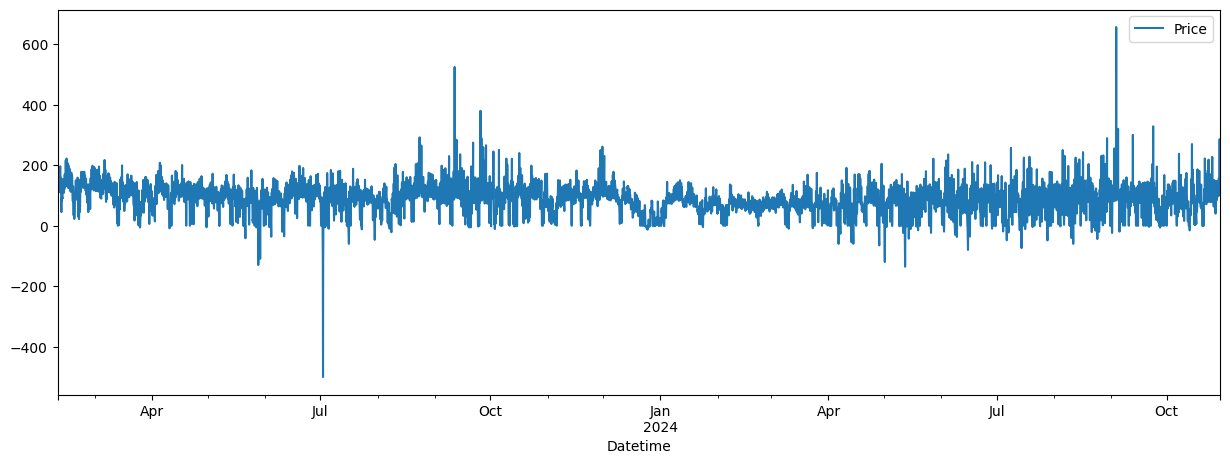

In [ ]:

WINDOW = df.iloc[:int(0.18 * (len(df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')
plt.show()

In [ ]:
date = '2024-10-29'
predictions = df.loc[date, 'prediction']

# Display the result
print(predictions)

Datetime
2024-10-29 22:00:00+00:00    102.871948
2024-10-29 21:00:00+00:00    102.871948
2024-10-29 20:00:00+00:00     98.723587
2024-10-29 19:00:00+00:00    118.422562
2024-10-29 18:00:00+00:00    160.957001
2024-10-29 17:00:00+00:00    222.613403
2024-10-29 16:00:00+00:00    325.634674
2024-10-29 15:00:00+00:00    244.977936
2024-10-29 14:00:00+00:00    185.442200
2024-10-29 13:00:00+00:00    147.121552
2024-10-29 12:00:00+00:00    121.733101
2024-10-29 11:00:00+00:00    115.761604
2024-10-29 10:00:00+00:00    115.761604
2024-10-29 09:00:00+00:00    115.772453
2024-10-29 08:00:00+00:00    115.772453
2024-10-29 07:00:00+00:00    130.870895
2024-10-29 06:00:00+00:00    140.768280
2024-10-29 05:00:00+00:00    140.768280
2024-10-29 04:00:00+00:00    119.343620
2024-10-29 03:00:00+00:00    119.601700
2024-10-29 02:00:00+00:00    104.509911
2024-10-29 01:00:00+00:00    110.060898
2024-10-29 00:00:00+00:00    111.630447
Name: prediction, dtype: float32


save models pickel
add 500 to axis -> z-standardisation might also work
features?
register
three way split for auto ml

